Database: https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils as image

In [4]:
train_dir = r'data/train'  # Location of training images
validation_dir = r'data/validation' #Location of validation images
test_dir =r'data/test' #Location of test images

In [5]:
class_names = ['Bee','Wasp'] #Creating a dictionary of class names according to the label

In [6]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [7]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',                 #Since we have two classes I am using a binary cross entropy
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# TRANSFER LEARNING USING VGG16 #

### PERFORMING DATA AUGMENTATION

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
#Plotting a graphical representation of the model
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot

keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## IMPORTING THE VGG 16 MODEL WEIGHTS for IMAGENET DATASET

In [10]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

## VGG16 ARCHITECTURE

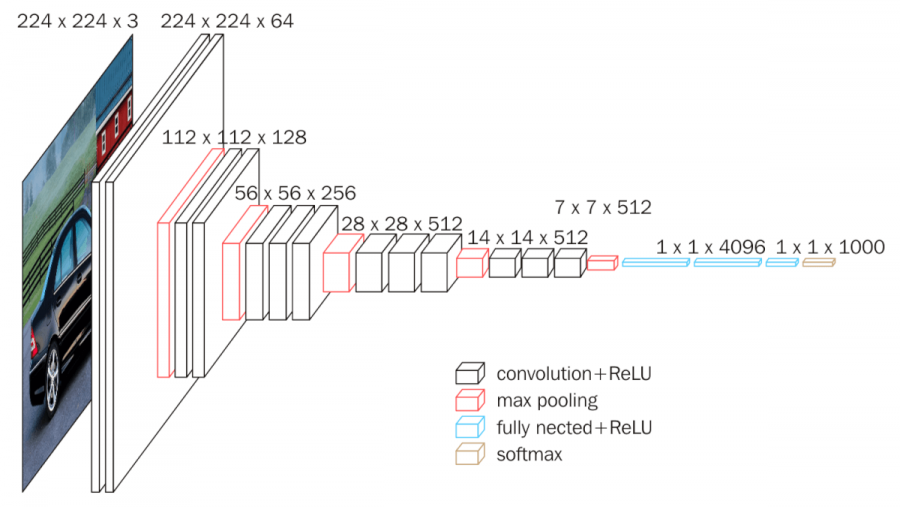

In [11]:
from IPython.core.display import Image, display
display(Image('https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png', width=700, unconfined=True))

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## ADDING LAYERS TO THE VGG 16 Architecture

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))    

In [14]:
#Plotting a graphical representation of the model
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot

# keras.utils.plot_model(model)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


**VGG 16 has a heavy architecture and hence if you do not have a dedicated GPU it may take 8-10 hours to training the whole network with the added layers, so you can freeze the VGG16 layers and use the pretrained weights and just train your additional layers; to do so uncomment the next code block**

In [16]:
# conv_base.trainable = False

I am using RMSprop as an optimizer with a very small learning rate for better results, you can try with Adam optimizer, but Adam optimizer works for some predefined values of learning rate, changing them may not give you a satisfactory result or maybe it will!! Hyperparmeter tuning is still a big challange!

In [17]:
from tensorflow.keras import optimizers
with tf.device("/device:GPU:0"):
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),         
              metrics=['acc'])

**Since the training process will take well enough time hence it is safe to create checkpoints after every epoch! 
Also you can resume the training process from where we left off in case it was interrupted or for fine-tuning the model**

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("models/CNN_Project_Model-{epoch:02d}.h5")

### TRAINING

In [19]:
with tf.device("/device:GPU:0"):
    history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[checkpoint_cb])

Epoch 1/30
100/100 [==============================] - 48s 382ms/step - loss: 0.4814 - acc: 0.7620 - val_loss: 0.3189 - val_acc: 0.8680
Epoch 2/30
100/100 [==============================] - 33s 331ms/step - loss: 0.3284 - acc: 0.8630 - val_loss: 0.2653 - val_acc: 0.8930
Epoch 3/30
100/100 [==============================] - 58s 578ms/step - loss: 0.2710 - acc: 0.8830 - val_loss: 0.1991 - val_acc: 0.9320
Epoch 4/30
100/100 [==============================] - 73s 737ms/step - loss: 0.2087 - acc: 0.9250 - val_loss: 1.1099 - val_acc: 0.7150
Epoch 5/30
100/100 [==============================] - 89s 898ms/step - loss: 0.1830 - acc: 0.9285 - val_loss: 0.2214 - val_acc: 0.9180
Epoch 6/30
100/100 [==============================] - 89s 889ms/step - loss: 0.1701 - acc: 0.9255 - val_loss: 0.2409 - val_acc: 0.9120
Epoch 7/30
100/100 [==============================] - 90s 899ms/step - loss: 0.1610 - acc: 0.9400 - val_loss: 0.3187 - val_acc: 0.8780
Epoch 8/30
100/100 [==============================] - 9

# After training:
* **Validation accuracy:96.1%**
* **Training accuracy:98.65%**

In [20]:
model.save("models/vgg16_cnn.h5")   #Saving the model to avoid retraining

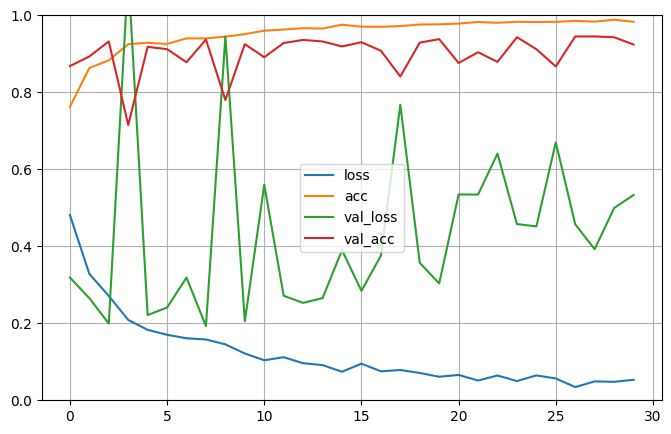

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Saving the model history at every epoch into a DataFrame as I don't wanna loose this data, even after using a dedicated GPU it took me an average of 90 seconds per epoch to train the complete model!

In [22]:
hist_df = pd.DataFrame(history.history) 

In [23]:
hist_df.head()

,loss,acc,val_loss,val_acc
0,0.481395,0.7620,0.318929,0.868
1,0.328427,0.8630,0.265309,0.893
2,0.270986,0.8830,0.199119,0.932
3,0.208734,0.9250,1.109862,0.715
4,0.182964,0.9285,0.221400,0.918


In [24]:
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## LOADING THE MODEL USING THE .h5 file
### MODEL ARCHITECTURE

In [25]:
model = tf.keras.models.load_model('models/vgg16_cnn.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## TESTING 

In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [27]:
newPath = 'images_from_net/new.jpg'
def getFromUrl(url, path):
    urlretrieve(url, path)
    return Image.open(path) 
    
def getImg(path):
    img_test=plt.imread(newPath)
    img_test=img_test/255.    
    return img_test[np.newaxis,:,:,:]

def prepareForPrediction(img):
    new_img=img.resize((150,150))
    new_img.save(newPath)
    return getImg(newPath)

def getResults(pred):
    result = int(pred[0][0].round())                                 #Rounding off the output to nearest class 0 or 1
    c = (1-pred[0][0]) * 100 if (result == 0) else pred[0][0]*100    #Calculating certainty of response
    return result, c

1/1 [==============================] - 0s 28ms/step


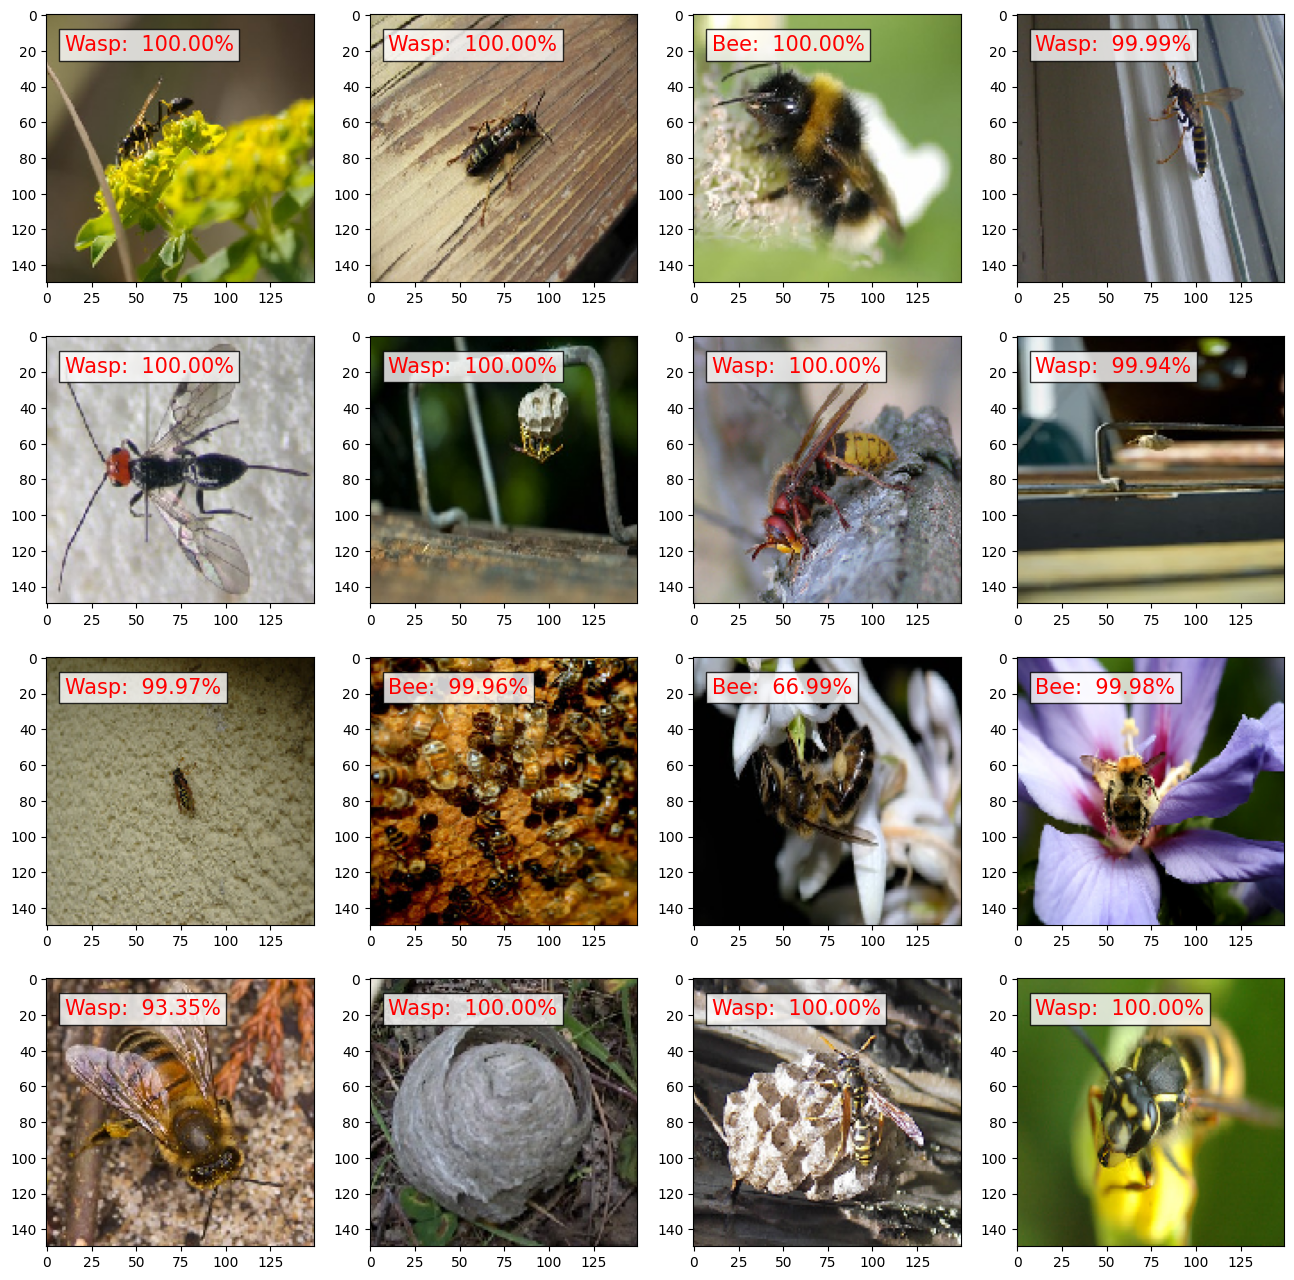

In [28]:
imgs, labels = next(test_generator)
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_t= np.expand_dims(imgs[i], axis=0)
    prediction = model.predict(img_t)
    
    result, c = getResults(prediction)
    value = '{tag}: {chance: .2f}%'.format(tag=class_names[result], chance=c)   
    plt.text(10, 20, value, color='red', fontsize=15, bbox=dict(facecolor='white', alpha=0.8)) #Displaying the class along with class value
    
    plt.imshow(imgs[i])

In [29]:
model.evaluate(test_generator, steps=50)

50/50 [==============================] - 15s 287ms/step - loss: 0.3778 - acc: 0.9340


[0.3777833580970764, 0.9340000152587891]

### **As we can see we get a testing accuracy of 95.8%**

In [30]:
from PIL import Image
from urllib.request import urlretrieve

In [33]:
def testImg(url='https://media-cldnry.s-nbcnews.com/image/upload/newscms/2018_49/2673506/181206-dominulus-cs-1016a.jpg', path='images_from_net/test.jpg'):
    img=getFromUrl(url, path)
    img_test = prepareForPrediction(img)
    pred = model.predict(img_test)                                   #Predicting the output
    result, c = getResults(pred)
    
    print('Output of Model: {c: .10f}'.format(c=c))                  #Creating a list of the outputprint(pred)
    value = '{tag}: {chance: .2f}%'.format(tag=class_names[result], chance=c)                                                            
    plt.title('Test Image')
    plt.text(int(img.size[0]/20), int(img.size[1]/10), value, color='red', fontsize=15, bbox=dict(facecolor='white', alpha=0.8)) #Displaying the class along with class value
    plt.imshow(img) 


1/1 [==============================] - 0s 49ms/step
Output of Model:  100.0000000000


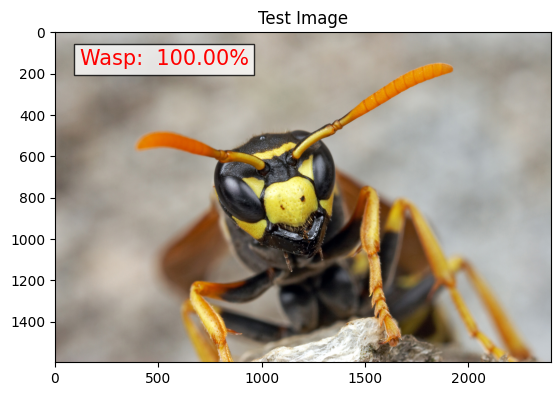

In [34]:
testImg('https://media-cldnry.s-nbcnews.com/image/upload/newscms/2018_49/2673506/181206-dominulus-cs-1016a.jpg')